In [15]:
import numpy as np
from steam_review_scraper import get_game_review 
import timeit

start_time = timeit.default_timer()

reviews = get_game_review(699130, language='english')

elapsed_time = timeit.default_timer() - start_time
print(f"Total Elapsed time: {elapsed_time:.2f} seconds")

Total Elapsed time: 161.75 seconds


C:\Users\tbont\AppData\Local\Temp\ipykernel_39120\2225325963.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df['processed_review'] = df['review'].str.lower().str.replace('[^\w\s]', '')
C:\Users\tbont\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\tbont\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


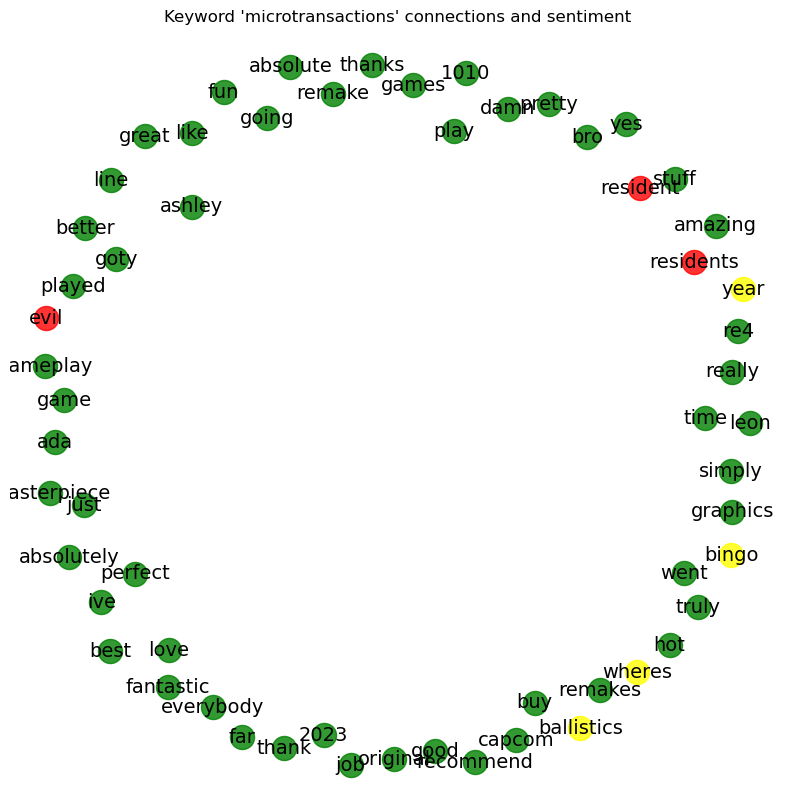

Total Elapsed time: 42.99 seconds


In [9]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import networkx as nx
from textblob import TextBlob


start_time = timeit.default_timer()

# Load your dataset
df = reviews
# Preprocess the text (lowercase and remove punctuation)
df['processed_review'] = df['review'].str.lower().str.replace('[^\w\s]', '')

# Extract features from the text using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['processed_review'])

# Apply Non-Negative Matrix Factorization (NMF) for topic modeling
n_topics = 10
nmf = NMF(n_components=n_topics, random_state=42)
nmf_matrix = nmf.fit_transform(tfidf_matrix)

# Function to get the top keywords for a given keyword
def get_top_keywords(keyword, top_n=10):
    words = vectorizer.get_feature_names()
    word_idx = words.index(keyword)
    topic_weights = nmf.components_[:, word_idx]
    top_topics = np.argsort(-topic_weights)[:top_n]
    
    top_keywords = []
    for topic in top_topics:
        topic_keywords = np.argsort(-nmf.components_[topic])[:top_n]
        top_keywords.extend([words[i] for i in topic_keywords])

    return set(top_keywords)

# Function to get sentiment for a given keyword
def get_sentiment(keyword):
    sentiment_scores = df[df['processed_review'].str.contains(keyword)]['review'].apply(lambda x: TextBlob(x).sentiment.polarity)
    avg_sentiment = sentiment_scores.mean()

    if avg_sentiment > 0.05:
        return "good"
    elif avg_sentiment < -0.05:
        return "bad"
    else:
        return "neutral"

# Function to visualize keyword connections and sentiment
def visualize_keywords(keyword):
    top_keywords = get_top_keywords(keyword)
    keyword_sentiments = {k: get_sentiment(k) for k in top_keywords}

    G = nx.Graph()
    for k, sentiment in keyword_sentiments.items():
        G.add_node(k, sentiment=sentiment)

    for k1, k2 in zip(top_keywords, top_keywords):
        if k1 != k2:
            weight = cosine_similarity(tfidf_matrix[:, vectorizer.vocabulary_[k1]], tfidf_matrix[:, vectorizer.vocabulary_[k2]])[0][0]
            G.add_edge(k1, k2, weight=weight)

    pos = nx.spring_layout(G, seed=42)
    colors = {'good': 'green', 'neutral': 'yellow', 'bad': 'red'}

    plt.figure(figsize=(10, 10))
    for sentiment, color in colors.items():
        nx.draw_networkx_nodes(G, pos, nodelist=[n for n, attr in G.nodes(data=True) if attr['sentiment'] == sentiment], node_color=color, alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=14)
    plt.title(f"Keyword '{keyword}' connections and sentiment")
    plt.axis("off")
    plt.show()

# Replace 'keyword' with your desired keyword
keyword = 'microtransactions'
visualize_keywords(keyword)

elapsed_time = timeit.default_timer() - start_time
print(f"Total Elapsed time: {elapsed_time:.2f} seconds")

In [10]:
import gensim

def get_closest_words(keyword, num_words=5):
    # Load pre-trained Word2Vec model
    model = gensim.models.KeyedVectors.load_word2vec_format('path/to/word2vec/model')

    # Get the closest words
    closest_words = model.similar_by_word(keyword, topn=num_words)

    return [word[0] for word in closest_words]


In [11]:
print(get_closest_words("cake"))

FileNotFoundError: [Errno 2] No such file or directory: 'path/to/word2vec/model'

In [13]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import networkx as nx
import matplotlib.pyplot as plt

# Download necessary nltk packages
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Read in the dataframe with game reviews
df = reviews

# Instantiate the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Define the topic of interest
topic = 'graphics'

# Create an empty graph
graph = nx.Graph()

# Add the topic node to the graph
graph.add_node(topic)

# Loop through each review and extract relevant words
for i, review in enumerate(df['review']):
    # Tokenize the review into words
    words = nltk.word_tokenize(review)
    
    # Filter out stop words
    words = [word.lower() for word in words if word.isalpha() and word.lower() not in nltk.corpus.stopwords.words('english')]
    
    # Calculate the sentiment score for the review
    sentiment = sia.polarity_scores(review)
    
    # Loop through each word in the review and add it to the graph
    for word in words:
        # Check if the word is already in the graph
        if word not in graph.nodes():
            # Add the word as a node
            graph.add_node(word)
            
        # Calculate the sentiment score for the word
        word_sentiment = sia.polarity_scores(word)
        
        # Determine the weight of the edge between the word and the topic
        weight = (word_sentiment['compound'] + sentiment['compound']) / 2
        
        # Add the edge between the word and the topic
        graph.add_edge(topic, word, weight=weight)
        
# Draw the graph
pos = nx.spring_layout(graph)
nx.draw_networkx_nodes(graph, pos, node_size=1000)
nx.draw_networkx_labels(graph, pos, font_size=12)
edges = graph.edges()
weights = [graph[u][v]['weight'] for u, v in edges]
nx.draw_networkx_edges(graph, pos, edgelist=edges, edge_color=weights, edge_cmap=plt.cm.Reds)

# Set the title and show the graph
plt.title(f'Words related to "{topic}" in game reviews')
plt.axis('off')
plt.show()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tbont\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tbont\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tbont\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


KeyboardInterrupt: 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tbont\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tbont\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tbont\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


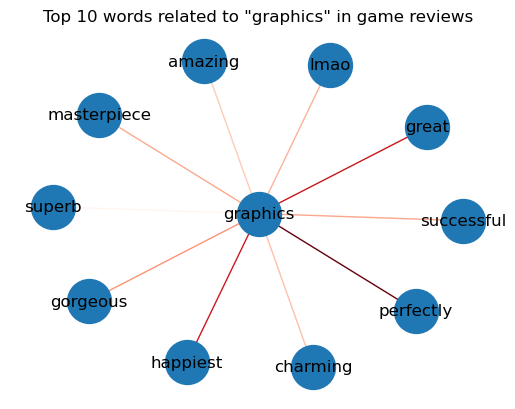

In [16]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import networkx as nx
import matplotlib.pyplot as plt

# Download necessary nltk packages
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Read in the dataframe with game reviews
df = reviews

# Instantiate the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Define the topic of interest
topic = 'graphics'

# Create an empty graph
graph = nx.Graph()

# Add the topic node to the graph
graph.add_node(topic)

# Loop through each review and extract relevant words
for i, review in enumerate(df['review']):
    # Tokenize the review into words
    words = nltk.word_tokenize(review)
    
    # Filter out stop words
    words = [word.lower() for word in words if word.isalpha() and word.lower() not in nltk.corpus.stopwords.words('english')]
    
    # Calculate the sentiment score for the review
    sentiment = sia.polarity_scores(review)
    
    # Loop through each word in the review and add it to the graph
    for word in words:
        # Check if the word is already in the graph
        if word not in graph.nodes():
            # Add the word as a node
            graph.add_node(word)
            
        # Calculate the sentiment score for the word
        word_sentiment = sia.polarity_scores(word)
        
        # Determine the weight of the edge between the word and the topic
        weight = (word_sentiment['compound'] + sentiment['compound']) / 2
        
        # Add the edge between the word and the topic
        graph.add_edge(topic, word, weight=weight)
        
# Sort the edges by weight and only show the top 10
edges = graph.edges(data=True)
edges = sorted(edges, key=lambda x: x[2]['weight'], reverse=True)[:10]
graph = nx.Graph(edges)

# Draw the graph
pos = nx.spring_layout(graph)
nx.draw_networkx_nodes(graph, pos, node_size=1000)
nx.draw_networkx_labels(graph, pos, font_size=12)
edge_weights = [edge[2]['weight'] for edge in edges]
nx.draw_networkx_edges(graph, pos, edgelist=edges, edge_color=edge_weights, edge_cmap=plt.cm.Reds)

# Set the title and show the graph
plt.title(f'Top 10 words related to "{topic}" in game reviews')
plt.axis('off')
plt.show()

In [20]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Download necessary nltk packages
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Read in the dataframe with game reviews
df = reviews

# Instantiate the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Define the topic of interest
topic = 'graphics'

# Create a TF-IDF vectorizer to convert reviews to numerical vectors
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')

# Calculate the TF-IDF matrix for the reviews
tfidf_matrix = vectorizer.fit_transform(df['review'])

# Calculate the cosine similarity between the topic and each word
topic_vector = vectorizer.transform([topic])
cosine_similarities = cosine_similarity(topic_vector, tfidf_matrix)

# Get the indices of the words sorted by their cosine similarity and sentiment score
word_indices = cosine_similarities.argsort()[0]
word_sentiments = []
for i in word_indices:
    word = vectorizer.get_feature_names()[i]
    review = df['review'][i]
    sentiment = sia.polarity_scores(review)['compound']
    word_sentiments.append((word, sentiment))

# Select the top 8 words with positive sentiment and the top 8 words with negative sentiment
good_words = [word for word, sentiment in sorted(word_sentiments, key=lambda x: (x[1], -cosine_similarities[0][vectorizer.vocabulary_[x[0]]]), reverse=True)[:8]]
bad_words = [word for word, sentiment in sorted(word_sentiments, key=lambda x: (x[1], -cosine_similarities[0][vectorizer.vocabulary_[x[0]]]))[:8]]

# Print the selected words and their sentiment scores
print('Good words:')
for word in good_words:
    print(f'{word}: {sia.polarity_scores(word)["compound"]}')
print('\nBad words:')
for word in bad_words:
    print(f'{word}: {sia.polarity_scores(word)["compound"]}')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tbont\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tbont\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tbont\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\tbont\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Good words:
chit: 0.0
13: 0.0
01at: 0.0
2021today: 0.0
arada: 0.0
haciendo: 0.0
ghost: -0.3182
disconnections: 0.0

Bad words:
approval: 0.4767
30ms: 0.0
coolllllllllllllllllllllllllllllll: 0.0
cheaper: 0.0
example: 0.0
clones: 0.0
according: 0.0
bengal: 0.0


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tbont\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tbont\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tbont\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


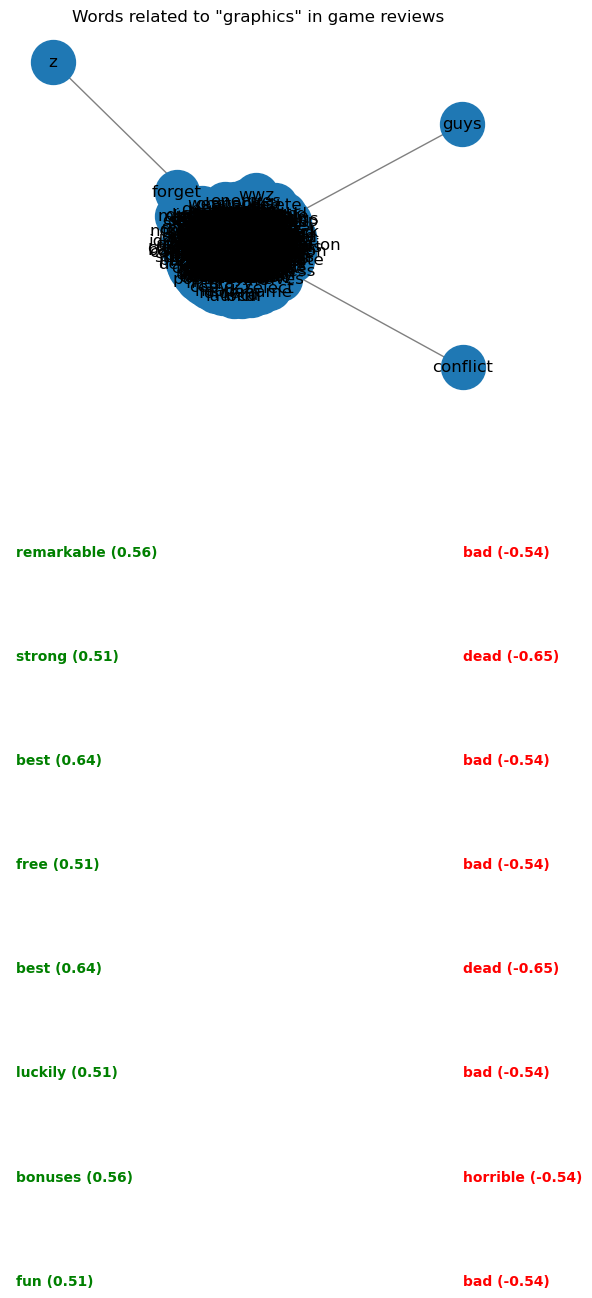

In [22]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import networkx as nx
import matplotlib.pyplot as plt

# Download necessary nltk packages
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Read in the dataframe with game reviews
df = reviews

# Instantiate the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Define the topic of interest
topic = 'graphics'

# Create an empty graph
graph = nx.Graph()

# Add the topic node to the graph
graph.add_node(topic)

# Define the number of good and bad sentiments to show
num_good_sentiments = 8
num_bad_sentiments = 8

# Define lists to store the top words for each sentiment category
good_words = []
bad_words = []

# Loop through each review and extract relevant words
for i, review in enumerate(df['review']):
    # Tokenize the review into words
    words = nltk.word_tokenize(review)
    
    # Filter out stop words
    words = [word.lower() for word in words if word.isalpha() and word.lower() not in nltk.corpus.stopwords.words('english')]
    
    # Calculate the sentiment score for the review
    sentiment = sia.polarity_scores(review)
    
    # Loop through each word in the review and add it to the graph
    for word in words:
        # Check if the word is already in the graph
        if word not in graph.nodes():
            # Add the word as a node
            graph.add_node(word)
            
        # Calculate the sentiment score for the word
        word_sentiment = sia.polarity_scores(word)
        
        # Determine the weight of the edge between the word and the topic
        weight = (word_sentiment['compound'] + sentiment['compound']) / 2
        
        # Add the edge between the word and the topic
        graph.add_edge(topic, word, weight=weight)
        
        # Update the good and bad word lists
        if word_sentiment['compound'] >= 0.5 and len(good_words) < num_good_sentiments:
            good_words.append((word, word_sentiment['compound']))
        elif word_sentiment['compound'] <= -0.5 and len(bad_words) < num_bad_sentiments:
            bad_words.append((word, word_sentiment['compound']))
            
        # Check if we have collected enough words
        if len(good_words) == num_good_sentiments and len(bad_words) == num_bad_sentiments:
            break
        
    # Check if we have collected enough words
    if len(good_words) == num_good_sentiments and len(bad_words) == num_bad_sentiments:
        break
        
# Draw the graph
pos = nx.spring_layout(graph)
nx.draw_networkx_nodes(graph, pos, node_size=1000)
nx.draw_networkx_labels(graph, pos, font_size=12)
edges = graph.edges()
weights = [graph[u][v]['weight'] for u, v in edges]
edge_colors = []
for u, v in edges:
    if u == topic:
        if graph[u][v]['weight'] >= 0.5:
            edge_colors.append('green')
        elif graph[u][v]['weight'] <= -0.5:
            edge_colors.append('red')
        else:
            edge_colors.append('gray')
    else:
        edge_colors.append('gray')
nx.draw_networkx_edges(graph, pos, edgelist=edges, edge_color=edge_colors, edge_cmap=plt.cm.Reds)

# Add labels to the good and bad words
for i, (word, sentiment) in enumerate(good_words):
    plt.text(-1, -1.5-i/2, f"{word} ({sentiment:.2f})", color='green', fontweight='bold')
for i, (word, sentiment) in enumerate(bad_words):
    plt.text(1, -1.5-i/2, f"{word} ({sentiment:.2f})", color='red', fontweight='bold')

# Set the title and show the graph
plt.title(f'Words related to "{topic}" in game reviews')
plt.axis('off')
plt.show()
